In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
ma = pd.read_table('/Users/guhan/Dropbox/ukbb-tools/13_mrp/biomarkers_mrp_rv_ma_exome_gbe.tsv.gz')
wb = pd.read_table('/Users/guhan/Dropbox/ukbb-tools/13_mrp/biomarkers_mrp_rv_exome_gbe.tsv.gz')
to_replace = ['log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav', 'posterior_prob_w_prior_odds_0.0005_study_similar_var_independent_sigma_m_mpc_pli_pav', 'log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_ptv', 'posterior_prob_w_prior_odds_0.0005_study_similar_var_independent_sigma_m_mpc_pli_ptv']
replacements = ['log_10_BF_study_independent_var_independent_sigma_m_mpc_pli_pav', 'posterior_prob_w_prior_odds_0.0005_study_independent_var_independent_sigma_m_mpc_pli_pav', 'log_10_BF_study_independent_var_independent_sigma_m_mpc_pli_ptv', 'posterior_prob_w_prior_odds_0.0005_study_independent_var_independent_sigma_m_mpc_pli_ptv']
for col1, col2 in zip(to_replace, replacements):
    ma[col1] = np.where(ma['num_pops'] == 1, ma[col2], ma[col1])

In [3]:
col = 'log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav'
ma = ma[ma[col] >= 5]
wb = wb[wb[col] >= 5]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


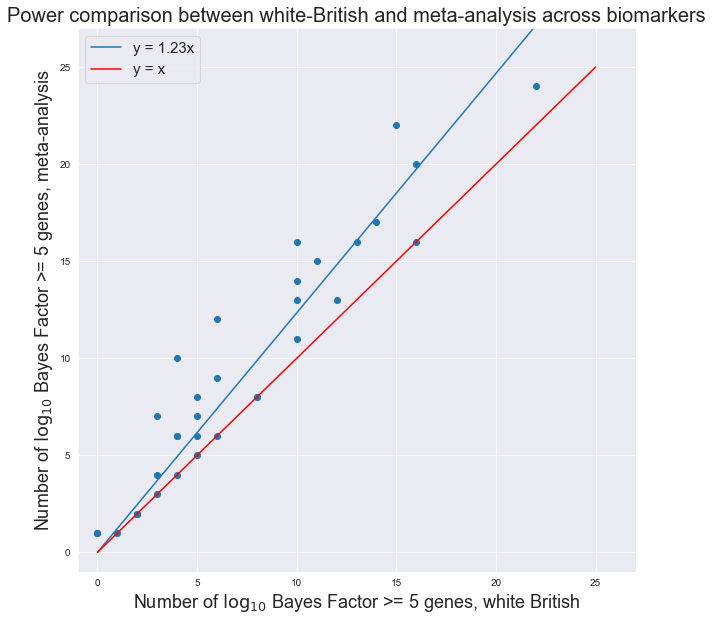

In [4]:
ma_hits = ma.groupby('GBE_short_name').count()['#GBE_ID'].reset_index()
ma_hits.columns = ['GBE_short_name', 'ma_hits']
wb_hits = wb.groupby('GBE_short_name').count()['#GBE_ID'].reset_index()
wb_hits.columns = ['GBE_short_name', 'wb_hits']

plt.figure(figsize=(10,10))
hits = ma_hits.merge(wb_hits, how='outer')
hits = hits.fillna(0)
sns.set_style('dark')
plt.scatter(hits['wb_hits'], hits['ma_hits'])

m, _, _, _ = np.linalg.lstsq(hits['wb_hits'][:,np.newaxis], hits['ma_hits'][:,np.newaxis])
x = np.linspace(0,25,26)
plt.plot(x, m[0][0]*x, label='y = ' + str(m[0][0])[:4] + 'x')
plt.xlabel('Number of $\log_{10}$ Bayes Factor >= 5 genes, white British', fontsize=18)
plt.ylabel('Number of $\log_{10}$ Bayes Factor >= 5 genes, meta-analysis', fontsize=18)
plt.title('Power comparison between white-British and meta-analysis across biomarkers', fontsize=20)
plt.xlim([-1,27])
plt.ylim([-1,27])
plt.plot(x, x, color='red', label='y = x')
plt.legend(fontsize=15)
plt.grid()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


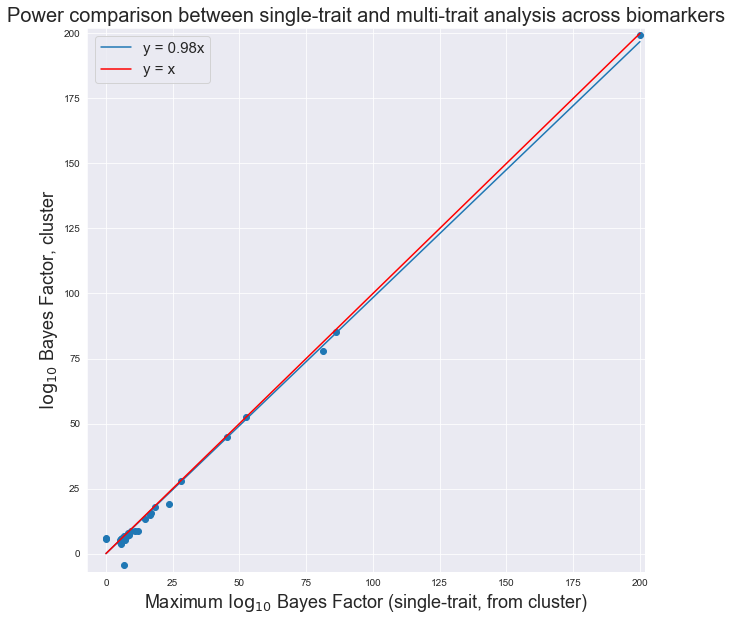

In [160]:
clusters = pd.read_table('biomarkers_clusters.tsv')
x, y = [], []
for cluster in clusters['cluster'].unique()[:1]:
    gbe_ids = list(clusters[clusters['cluster'] == cluster]['GBE_ID'])
    wb_hits = list(wb[(wb['#GBE_ID'].isin(gbe_ids)) & (wb['log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav'] >= 5)]['gene'])
    multitrait = pd.read_table('white_british_' + str(cluster) + '_gene_maf_0.01_se_100.0.tsv.gz')
    multitrait_hits = list(multitrait[multitrait['log_10_BF_study_independent_var_independent_sigma_m_mpc_pli_pav'] >= 5]['gene'])
    hits = list(set(wb_hits + multitrait_hits))
    for hit in hits:
        multitrait_bf = multitrait[multitrait['gene'] == hit]['log_10_BF_study_independent_var_independent_sigma_m_mpc_pli_pav']
        wb_bf = wb[(wb['gene'] == hit) & (wb['#GBE_ID'].isin(gbe_ids))]['log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav']
        if len(multitrait_bf) > 0:
            y.append(multitrait_bf.values[0])
        else:
            y.append(0)
        if len(wb_bf) > 0:
            x.append(max(wb_bf.values))
        else:
            x.append(0)
plt.figure(figsize=(10,10))
sns.set_style('dark')
plt.scatter(x, y)

m, _, _, _ = np.linalg.lstsq(np.array(x)[:,np.newaxis], np.array(y)[:,np.newaxis])
x = np.linspace(0,200,201)
plt.plot(x, m[0][0]*x, label='y = ' + str(m[0][0])[:4] + 'x')
plt.xlabel('Maximum $\log_{10}$ Bayes Factor (single-trait, from cluster)', fontsize=18)
plt.ylabel('$\log_{10}$ Bayes Factor, cluster', fontsize=18)
plt.title('Power comparison between single-trait and multi-trait analysis across biomarkers', fontsize=20)
plt.xlim([-7,202])
plt.ylim([-7,202])
plt.plot(x, x, color='red', label='y = x')
plt.legend(fontsize=15)
plt.grid()
plt.show()